In [77]:
import numpy as np
import pandas as pd
import scipy

import matplotlib as mpl
import matplotlib.pyplot as plt

import io
import requests
from zipfile import ZipFile
from pathlib import Path
import calendar

# Local Effects of Climate Change

## Question

> How did the local climate in Gießen change over the past 70 years?

## Data sources

We need data for temperature, (relative) humidity, and precipitation collected near Gießen. Such data has been collected by Deutscher Wetterdienst (DWD) and is publically available via their open-data portal at https://opendata.dwd.de.

### Downloading the data

The function below will download are tarball containing the measurements as well as some metadata from a given URL. The tarball is extracted and placed in a specified directory.

In [78]:
def download_and_extract(
    url: str,
    output_path: Path = Path('tmp/dwd')
) -> None:
    """download DWD climate data from url and extract."""
    output_path.mkdir(exist_ok=True, parents=True)

    (ZipFile(io.BytesIO(requests.get(url).content))
     .extractall(path=output_path)
    )

In [79]:
TMP_DIRECTORY = Path("_dwd")
DWD_data = 'https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/'
temperature_humidity = 'air_temperature/historical/stundenwerte_TU_01639_19500101_20221231_hist.zip'
precipitation = 'precipitation/historical/stundenwerte_RR_01639_19970320_20221231_hist.zip'

download_and_extract(url=DWD_data + temperature_humidity, output_path=TMP_DIRECTORY / "temperature_and_humidity")
download_and_extract(url=DWD_data + precipitation, output_path=TMP_DIRECTORY / "precipitation")

## Metadata

The downloaded datasets include specific *metadata files*. These contain the units, encodings, and meaning of the columns.

`(A)` For dates and measurement values, find out in which format they are available, and consider how you might convert them to usable and correct values for analysis with `pandas`.

* Dates are encoded in the format (year)(month)(day)(time in 24 hour format).
    * by default, pandas will import these as `int64` type.
    * the time encoding changed in 1996!
        * 1996-10-01 and later: UTC time
        * Before 1996-10-01: MEZ time (UTC + 1h)
    * have to convert to suitable date format
        * need to conform to the different time zone encodings
* measurements are given with *physical units*
    * Temperature:  ${}^{\circ}\textrm{C}$
    * Relative humidity: %
    * precipitation: mm

## Data Import and Cleaning

### `(R)` [2 Punkte] Importing

Import the temperature and humidity data into a DataFrame `df_th`, and the precipitation data into a DataFrame `df_p`. Consider which columns you want to keep.

In [80]:
df_th = pd.read_csv(TMP_DIRECTORY / "temperature_and_humidity" / "produkt_tu_stunde_19500101_20221231_01639.txt", sep=";", na_values=-999, encoding="latin1", usecols=["MESS_DATUM", "TT_TU", "RF_TU"])
df_th

,MESS_DATUM,TT_TU,RF_TU
0,1950010101,-3.6,74.0
1,1950010102,-3.5,74.0
2,1950010103,-3.5,73.0
3,1950010104,-4.2,74.0
4,1950010105,-4.3,74.0
...,...,...,...
639896,2022123119,13.7,71.0
639897,2022123120,14.0,67.0
639898,2022123121,14.6,62.0
639899,2022123122,13.9,65.0


In [81]:
df_p = pd.read_csv(TMP_DIRECTORY / "precipitation" / "produkt_rr_stunde_19970320_20221231_01639.txt", sep=";", na_values=-999, encoding="latin1", usecols=["MESS_DATUM", "  R1", "RS_IND", "WRTR"])
df_p 

,MESS_DATUM,R1,RS_IND,WRTR
0,1997032011,0.0,1.0,NaN
1,1997032012,0.0,1.0,NaN
2,1997032013,0.0,1.0,NaN
3,1997032014,0.0,0.0,NaN
4,1997032015,0.0,0.0,NaN
...,...,...,...,...
224913,2022123119,0.0,0.0,0.0
224914,2022123120,0.0,0.0,0.0
224915,2022123121,0.0,0.0,0.0
224916,2022123122,0.0,0.0,0.0


### `(A)` [3 Punkte] Tweaking

Modify the dataframes in the following manner:

* Rename the column labels in a reasonable manner.
* Convert the datetimes at which the measurements were conducted to a proper Pandas `datetime` format (make them refer to UTC) and make this column the index of the DataFrame.
* Remove all lines with missing values (due to, e.g., failed measurements)
* Apply type conversions where appropriate.


#### Notes
* Be careful when removing "missing values" (as they are called in [the documentation of the dataset](https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/precipitation/historical/DESCRIPTION_obsgermany_climate_hourly_precipitation_historical_en.pdf)). There might by many "missing values" in some colums but you will still want to keep the line in the DataFrame in order to notlose too many measurements. Counting the number of missing values in each column might help get an overview.
* we suggest placing all required code in a dedicated tweaking function, e.g.

```python
def tweak_temperature_and_humidity(df: pd.DataFrame) -> pd.DataFrame:
    # your code goes here

df_th = tweak_temperature_and_humidity(df_th)
```

In [82]:

def tweak_temperature_and_humidity(df: pd.DataFrame) -> pd.DataFrame:
    
    def tweak_time(time):
        return (pd.to_datetime(time, format='%Y%m%d%H') + pd.Timedelta(hours=1) * (time <= 19961001)).dt.tz_localize('UTC')
    
    return ( df
                .assign(datetime = tweak_time(df['MESS_DATUM']))
                .rename(columns={"TT_TU": "temperature", "RF_TU": "humidity"})
                .drop(columns='MESS_DATUM')
                .dropna()
                .astype({'temperature': 'float', 'humidity': np.uint8})
                .set_index('datetime')
            )
    
df_th = tweak_temperature_and_humidity(df_th)

def tweak_precipitation(df: pd.DataFrame) -> pd.DataFrame:

    return ( df
                .assign(datetime = pd.to_datetime(df['MESS_DATUM'], format='%Y%m%d%H').dt.tz_localize('UTC'))
                .rename(columns={'  R1': 'precipitation', 'RS_IND': 'precipitation_indicator', 'WRTR': 'precipitation_form'})
                .astype({'precipitation': 'float', 'precipitation_indicator': 'category', 'precipitation_form': 'category'})
                .drop(columns='MESS_DATUM')
                .set_index('datetime')
                
            )

df_p = tweak_precipitation(df_p)     

df_p, df_th


(                           precipitation precipitation_indicator   
 datetime                                                           
 1997-03-20 11:00:00+00:00            0.0                     1.0  \
 1997-03-20 12:00:00+00:00            0.0                     1.0   
 1997-03-20 13:00:00+00:00            0.0                     1.0   
 1997-03-20 14:00:00+00:00            0.0                     0.0   
 1997-03-20 15:00:00+00:00            0.0                     0.0   
 ...                                  ...                     ...   
 2022-12-31 19:00:00+00:00            0.0                     0.0   
 2022-12-31 20:00:00+00:00            0.0                     0.0   
 2022-12-31 21:00:00+00:00            0.0                     0.0   
 2022-12-31 22:00:00+00:00            0.0                     0.0   
 2022-12-31 23:00:00+00:00            0.0                     0.0   
 
                           precipitation_form  
 datetime                                      
 1997

### `(T)` [2 Punkte] Merge DataFrames

[Merge](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.merge.html) the DataFrame containing the data for the temperature and the humidity with that containing the values for the amount of precipitation.

The new DataFrame (you might call it `df_weather`) shall also have the datetimes of the measurements in the index.

#### Notes

* The time interval of available measurements in the *merged* DataFrame is determined by the DataFrame with the smaller interval.
* Try to use the new DataFrame in the following tasks. If you do not succeed in merging the two DataFrames it is also fine to use the individual DataFrames to solve the tasks.

In [83]:
df_weather = (df_th
              .merge(df_p, on='datetime', how='inner',)
)
df_weather

,temperature,humidity,precipitation,precipitation_indicator,precipitation_form
datetime,,,,,
1997-03-20 11:00:00+00:00,2.5,79,0.0,1.0,NaN
1997-03-20 12:00:00+00:00,2.5,83,0.0,1.0,NaN
1997-03-20 13:00:00+00:00,3.3,66,0.0,1.0,NaN
1997-03-20 14:00:00+00:00,3.3,65,0.0,0.0,NaN
1997-03-20 15:00:00+00:00,3.5,63,0.0,0.0,NaN
...,...,...,...,...,...
2022-12-31 19:00:00+00:00,13.7,71,0.0,0.0,0.0
2022-12-31 20:00:00+00:00,14.0,67,0.0,0.0,0.0
2022-12-31 21:00:00+00:00,14.6,62,0.0,0.0,0.0


## Data Visualization

In the following tasks you will asked to visualise certain aspects of the data.

Try to make the visualisations as "compelling", understandable, and expressive as possible by adding e.g. axes labels (with units if required), plot titles and reasonable scales

### `(A)` [3 Punkte] Seasonal contributions to precipitation

Determine the contribution to the total yearly amount of precipitation of each [**meteorological season**](https://www.dwd.de/DE/service/lexikon/Functions/glossar.html?lv3=101324&lv2=101304). Visualise the results in a single plot and make sure that the contributions of the single seasons can be distinguished.

<Axes: title={'center': 'yearly precipitation with contributions from seasons'}, xlabel='precipitation height / mm', ylabel='year'>

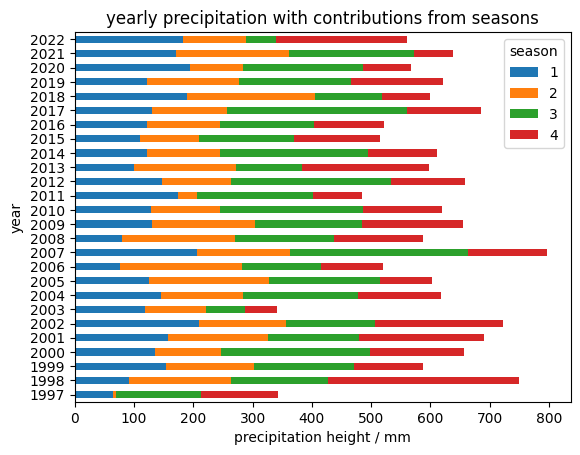

In [130]:
(
    df_p
    .assign(
        year=df_p.index.year,
        season=df_p.index.month % 12 // 3 + 1
    )
    .pivot_table(
        index="year",
        columns="season",
        values="precipitation",
        aggfunc=np.sum
    )
    .plot
    .barh(
        stacked=True,
        xlabel="precipitation height / mm",
        ylabel="year", 
        title="yearly precipitation with contributions from seasons"
    )
)

### `(A)` [2 Punkte] The Summer of 2003

By looking at the plot from the previous task it becomes obvious that the amount of precipitation in 2003 was much lower than in other years.

Search for hints in the data that support this observation. Generate two plots that further explain the observation (e.g. distributions, seasonal effects).

*Note*: In fact, the [summer of 2003](https://en.wikipedia.org/wiki/2003_European_heat_wave) has been quite special from a metereological point of view.

Ellipsis

## Data Analysis

### `(A)` [2 Punkte] Correlation between precipitation and humidity

Make a plot that correlates the amount of *actually fallen liquid precipitation* with the relative humidity. Also add temperature information in the *same* plot.

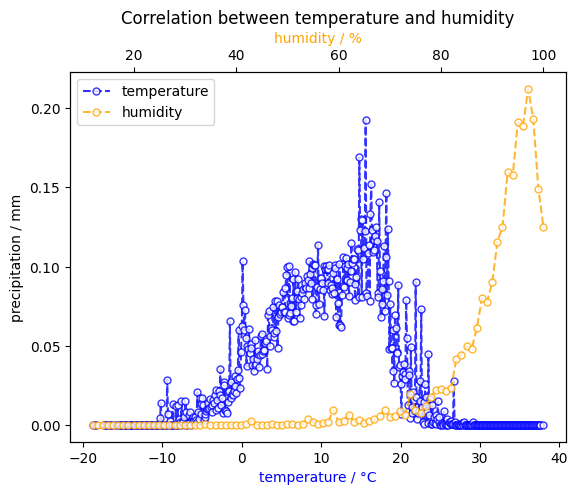

In [128]:

temp = df_weather.groupby('temperature').precipitation.mean()
hum = df_weather.groupby('humidity').precipitation.mean()


# Create a figure and an axis
fig, ax1 = plt.subplots()

# Plot the first set of data on the first axis
ax1.plot(
        temp, 
        label='temperature', 
        color='blue', 
        linestyle='--',
        alpha=0.8,
        marker = 'o',
        markersize = 5,
        markerfacecolor = 'white'
        )
ax1.set_xlabel('temperature / °C', color='blue')
ax1.set_ylabel('precipitation / mm')

# Create a second axis that shares the same y-axis
ax2 = ax1.twiny()

# Plot the second set of data on the second axis
ax2.plot(
        hum, 
        label='humidity', 
        color='orange', 
        linestyle='--',
        alpha=0.8,
        marker = 'o',
        markersize = 5,
        markerfacecolor = 'white'
        )
ax2.set_xlabel('humidity / %', color='orange')

ax1.set_title('Correlation between temperature and humidity')

fig.legend(loc="upper left", bbox_to_anchor=(0,1), bbox_transform=ax1.transAxes)

### `(A)` [6 Punkte] Correlation between humidity and temperature

* Make a plot that correlates the relative humidity with the temperature. Can you see a trend?

<Axes: title={'center': 'Correlation between temperature and humidity'}, xlabel='temperature / °C', ylabel='humidity / %'>

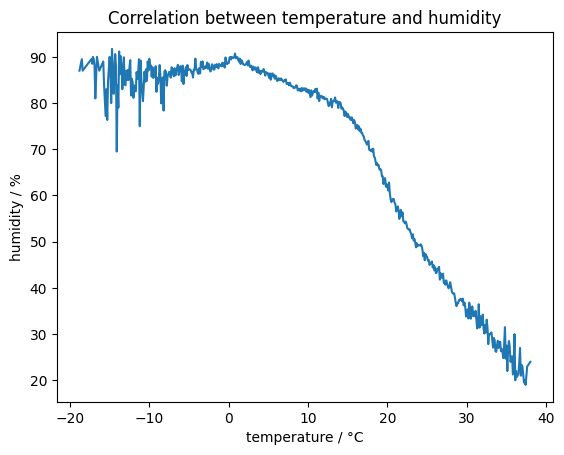

In [93]:
(df_weather
    .groupby('temperature').humidity.mean()
    .plot(
        title='Correlation between temperature and humidity',
        xlabel='temperature / °C',
        ylabel='humidity / %')
)

"""Je höher die Temperatur, desto niedriger die Luftfeuchtigkeit."""

* Make another plot that shows the (mean) temperature and the (mean) relative humidity over the course of the day.

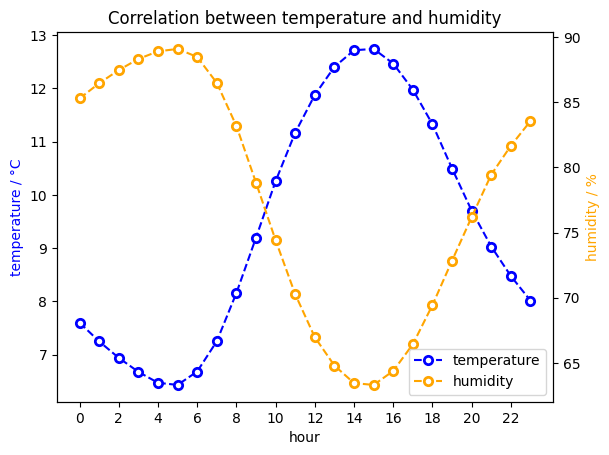

In [116]:


temp = df_th.groupby(df_th.index.hour).temperature.mean()
hum = df_th.groupby(df_th.index.hour).humidity.mean()


# Create a figure and an axis
fig, ax1 = plt.subplots()

# Plot the first set of data on the first axis
ax1.plot(temp, label='temperature', color='blue', linestyle='--', marker='o', markerfacecolor='white', markeredgewidth=2, markeredgecolor='blue')
ax1.set_ylabel('temperature / °C', color='blue')
ax1.set_xlabel('hour')
ax1.set_xticks(np.arange(0, 24, 2))

# Create a second axis that shares the same x-axis
ax2 = ax1.twinx()

# Plot the second set of data on the second axis
ax2.plot(hum, label='humidity', color='orange', linestyle='--', marker='o', markerfacecolor='white', markeredgewidth=2, markeredgecolor='orange')
ax2.set_ylabel('humidity / %', color='orange')

ax1.set_title('Correlation between temperature and humidity')

fig.legend(loc="lower right", bbox_to_anchor=(1,0), bbox_transform=ax1.transAxes)